In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from itertools import combinations
from sklearn.covariance import EllipticEnvelope
import optuna
import shap

In [2]:
df = pd.read_csv("Telco_customer_churn.csv")
df.drop(columns=['customerID'], inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.select_dtypes(include=np.number).median(), inplace=True)

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

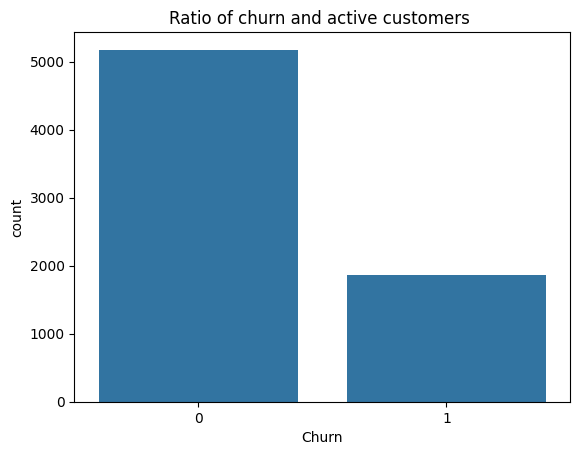

In [7]:
sns.countplot(x="Churn", data=df)
plt.title("Ratio of churn and active customers ")
plt.show()

In [8]:
df['MonthlyCharges_to_Tenure'] = df['MonthlyCharges'] / (df['tenure'] + 1)
df['TotalCharges_to_Tenure'] = df['TotalCharges'] / (df['tenure'] + 1)
df['Tenure_Bucket'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72, 100], labels=[1, 2, 3, 4, 5])
df['Tenure_Bucket'] = le.fit_transform(df['Tenure_Bucket'])

In [9]:
X = df.drop(columns=['Churn'])
y = df['Churn']

interaction_features = {}

for col1, col2 in combinations(X.columns, 2):
    interaction_features[f"{col1}_{col2}"] = X[col1] * X[col2]

df = pd.DataFrame(interaction_features)

X = pd.concat([X, df], axis=1)

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['CustomerSegment'] = kmeans.fit_predict(X)

In [11]:
# Define the segments of the customers
#     0: "High Churn Risk",
#     1: "Loyal Low-Spenders",
#     2: "Price-Sensitive",
#     3: "High-Value Loyal Customers",
#     4: "Contract-Bound"

In [12]:
df.head()

,gender_SeniorCitizen,gender_Partner,gender_Dependents,gender_tenure,gender_PhoneService,gender_MultipleLines,gender_InternetService,gender_OnlineSecurity,gender_OnlineBackup,gender_DeviceProtection,...,MonthlyCharges_MonthlyCharges_to_Tenure,MonthlyCharges_TotalCharges_to_Tenure,MonthlyCharges_Tenure_Bucket,TotalCharges_MonthlyCharges_to_Tenure,TotalCharges_TotalCharges_to_Tenure,TotalCharges_Tenure_Bucket,MonthlyCharges_to_Tenure_TotalCharges_to_Tenure,MonthlyCharges_to_Tenure_Tenure_Bucket,TotalCharges_to_Tenure_Tenure_Bucket,CustomerSegment
0,0,0,0,0,0,0,0,0,0,0,...,445.511250,445.511250,0.0,445.511250,445.511250,0.0,222.755625,0.000000,0.000000,0
1,0,0,0,34,1,0,0,2,0,2,...,92.665786,3074.486429,113.9,3074.486429,102006.007143,3779.0,87.842469,3.254286,107.971429,4
2,0,0,0,2,1,0,0,2,2,0,...,966.607500,1941.292500,0.0,1941.292500,3898.807500,0.0,647.097500,0.000000,0.000000,0
3,0,0,0,45,0,1,0,2,0,2,...,38.897609,1692.689674,84.6,1692.689674,73660.012228,3681.5,36.797602,1.839130,80.032609,0
4,0,0,0,0,0,0,0,0,0,0,...,1666.163333,3573.885000,0.0,3573.885000,7665.907500,0.0,1191.295000,0.000000,0.000000,0


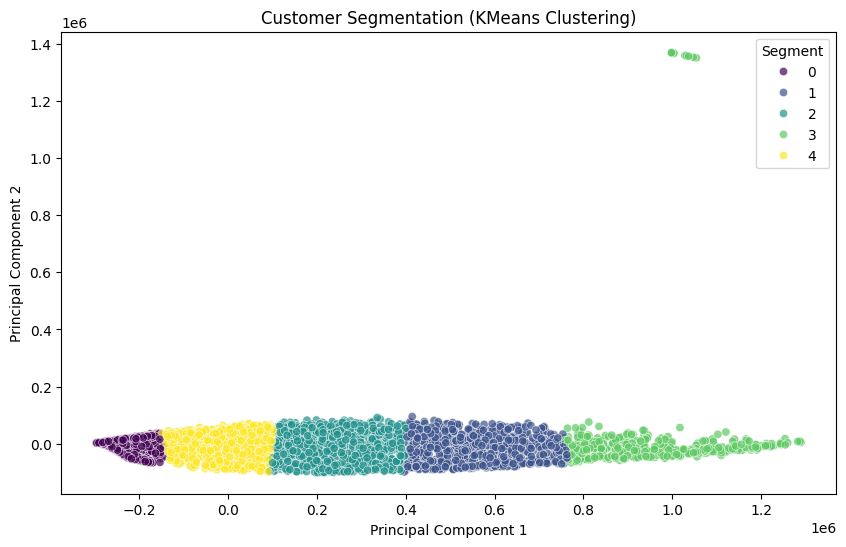

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='CustomerSegment', palette='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segmentation (KMeans Clustering)")
plt.legend(title="Segment")
plt.show()

In [14]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)

In [15]:
df.head()

,gender_SeniorCitizen,gender_Partner,gender_Dependents,gender_tenure,gender_PhoneService,gender_MultipleLines,gender_InternetService,gender_OnlineSecurity,gender_OnlineBackup,gender_DeviceProtection,...,TotalCharges_MonthlyCharges_to_Tenure,TotalCharges_TotalCharges_to_Tenure,TotalCharges_Tenure_Bucket,MonthlyCharges_to_Tenure_TotalCharges_to_Tenure,MonthlyCharges_to_Tenure_Tenure_Bucket,TotalCharges_to_Tenure_Tenure_Bucket,CustomerSegment,PCA1,PCA2,Anomaly
0,0,0,0,0,0,0,0,0,0,0,...,445.511250,445.511250,0.0,222.755625,0.000000,0.000000,0,-295285.302910,2785.919792,1
1,0,0,0,34,1,0,0,2,0,2,...,3074.486429,102006.007143,3779.0,87.842469,3.254286,107.971429,4,-134512.676342,-297.646225,1
2,0,0,0,2,1,0,0,2,2,0,...,1941.292500,3898.807500,0.0,647.097500,0.000000,0.000000,0,-289772.652875,3656.522302,1
3,0,0,0,45,0,1,0,2,0,2,...,1692.689674,73660.012228,3681.5,36.797602,1.839130,80.032609,0,-164500.817889,-22746.394669,1
4,0,0,0,0,0,0,0,0,0,0,...,3573.885000,7665.907500,0.0,1191.295000,0.000000,0.000000,0,-284124.555368,4846.192204,1


In [16]:
mi_scores = mutual_info_classif(X, y)
selected_features = X.columns[np.argsort(mi_scores)[-20:]]
X = X[selected_features]

In [17]:
mi_scores

array([0.00381962, 0.00995998, 0.01886267, 0.01005244, 0.07961884,
       0.00394587, 0.00394493, 0.06007033, 0.06643813, 0.0535287 ,
       0.04657558, 0.06083343, 0.02734705, 0.02647139, 0.09539726,
       0.02522046, 0.04321112, 0.04448702, 0.04391366, 0.1328052 ,
       0.03635233, 0.07253595, 0.00479447, 0.00397761, 0.00211264,
       0.03565573, 0.00761456, 0.00288021, 0.02599987, 0.01977776,
       0.01904258, 0.01706754, 0.02443787, 0.01595201, 0.01465996,
       0.03298916, 0.        , 0.02156528, 0.02775877, 0.01275282,
       0.05468369, 0.01899216, 0.02129864, 0.        , 0.        ,
       0.02693464, 0.00412874, 0.00093709, 0.02317471, 0.00314894,
       0.        , 0.00034895, 0.        , 0.00585122, 0.00293795,
       0.        , 0.01037007, 0.0255485 , 0.00745056, 0.02264899,
       0.03074343, 0.02018642, 0.0036306 , 0.01506641, 0.03669047,
       0.00634495, 0.00372156, 0.02316893, 0.0447316 , 0.02774717,
       0.02561955, 0.03617649, 0.01242587, 0.01696584, 0.05888

In [18]:
X

,OnlineSecurity_TotalCharges_to_Tenure,PaymentMethod_MonthlyCharges_to_Tenure,StreamingMovies_MonthlyCharges_to_Tenure,DeviceProtection_MonthlyCharges_to_Tenure,Contract_Tenure_Bucket,tenure_InternetService,TechSupport_MonthlyCharges_to_Tenure,InternetService_MonthlyCharges_to_Tenure,OnlineSecurity_MonthlyCharges_to_Tenure,Contract,Contract_TotalCharges,PaperlessBilling_MonthlyCharges_to_Tenure,tenure_Contract,Contract_MonthlyCharges_to_Tenure,Contract_TotalCharges_to_Tenure,Contract_MonthlyCharges,PhoneService_MonthlyCharges_to_Tenure,MonthlyCharges_MonthlyCharges_to_Tenure,MonthlyCharges_to_Tenure_TotalCharges_to_Tenure,MonthlyCharges_to_Tenure
0,0.000000,29.850000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.00,14.925000,0,0.000000,0.000000,0.00,0.000000,445.511250,222.755625,14.925000
1,107.971429,4.881429,0.000000,3.254286,2,0,0.000000,0.000000,3.254286,1,1889.50,0.000000,34,1.627143,53.985714,56.95,1.627143,92.665786,87.842469,1.627143
2,72.100000,53.850000,0.000000,0.000000,0,0,0.000000,0.000000,35.900000,0,0.00,17.950000,0,0.000000,0.000000,0.00,17.950000,966.607500,647.097500,17.950000
3,80.032609,0.000000,0.000000,1.839130,2,0,1.839130,0.000000,1.839130,1,1840.75,0.000000,45,0.919565,40.016304,42.30,0.000000,38.897609,36.797602,0.919565
4,0.000000,47.133333,0.000000,0.000000,0,2,0.000000,23.566667,0.000000,0,0.00,23.566667,0,0.000000,0.000000,0.00,23.566667,1666.163333,1191.295000,23.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,159.240000,10.176000,6.784000,6.784000,1,0,6.784000,0.000000,6.784000,1,1990.50,3.392000,24,3.392000,79.620000,84.80,3.392000,287.641600,270.071040,3.392000
7039,0.000000,1.413699,2.827397,2.827397,3,72,0.000000,1.413699,0.000000,1,7362.90,1.413699,72,1.413699,100.861644,103.20,1.413699,145.893699,142.587968,1.413699
7040,57.741667,4.933333,0.000000,0.000000,0,0,0.000000,0.000000,4.933333,0,0.00,2.466667,0,0.000000,0.000000,0.00,0.000000,73.013333,71.214722,2.466667
7041,0.000000,44.640000,0.000000,0.000000,0,4,0.000000,14.880000,0.000000,0,0.00,14.880000,0,0.000000,0.000000,0.00,14.880000,1107.072000,912.441600,14.880000


In [19]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

In [20]:
X_pca

array([[-2.41591765e+03, -2.56736586e+02, -3.19721607e+01, ...,
        -1.06563085e+01,  1.44843230e+01,  1.82126067e+00],
       [-5.07353060e+02, -3.34525172e+02, -3.05306193e+02, ...,
         1.35954164e+01,  2.44241472e+00, -1.11398464e+00],
       [-2.45342021e+03,  2.06834629e+02,  4.53470491e+02, ...,
        -9.64509189e+00,  3.24623194e+01,  8.28423242e+00],
       ...,
       [-2.39415261e+03, -4.34312205e+02, -3.93488654e+02, ...,
        -8.54382632e+00, -9.20427753e-03, -1.30649514e+00],
       [-2.47018536e+03,  4.79696761e+02,  5.74812934e+02, ...,
        -8.04139497e+00,  1.71906116e+01, -4.52786559e+00],
       [ 1.12699848e+04,  2.42239214e+02,  2.11221569e+02, ...,
         9.95539383e+00,  2.75798534e+00,  9.68325386e-01]])

In [21]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [22]:
X.head()

,OnlineSecurity_TotalCharges_to_Tenure,PaymentMethod_MonthlyCharges_to_Tenure,StreamingMovies_MonthlyCharges_to_Tenure,DeviceProtection_MonthlyCharges_to_Tenure,Contract_Tenure_Bucket,tenure_InternetService,TechSupport_MonthlyCharges_to_Tenure,InternetService_MonthlyCharges_to_Tenure,OnlineSecurity_MonthlyCharges_to_Tenure,Contract,Contract_TotalCharges,PaperlessBilling_MonthlyCharges_to_Tenure,tenure_Contract,Contract_MonthlyCharges_to_Tenure,Contract_TotalCharges_to_Tenure,Contract_MonthlyCharges,PhoneService_MonthlyCharges_to_Tenure,MonthlyCharges_MonthlyCharges_to_Tenure,MonthlyCharges_to_Tenure_TotalCharges_to_Tenure,MonthlyCharges_to_Tenure
0,0.000000,29.850000,0.0,0.000000,0,0,0.00000,0.000000,0.000000,0,0.00,14.925000,0,0.000000,0.000000,0.00,0.000000,445.511250,222.755625,14.925000
1,107.971429,4.881429,0.0,3.254286,2,0,0.00000,0.000000,3.254286,1,1889.50,0.000000,34,1.627143,53.985714,56.95,1.627143,92.665786,87.842469,1.627143
2,72.100000,53.850000,0.0,0.000000,0,0,0.00000,0.000000,35.900000,0,0.00,17.950000,0,0.000000,0.000000,0.00,17.950000,966.607500,647.097500,17.950000
3,80.032609,0.000000,0.0,1.839130,2,0,1.83913,0.000000,1.839130,1,1840.75,0.000000,45,0.919565,40.016304,42.30,0.000000,38.897609,36.797602,0.919565
4,0.000000,47.133333,0.0,0.000000,0,2,0.00000,23.566667,0.000000,0,0.00,23.566667,0,0.000000,0.000000,0.00,23.566667,1666.163333,1191.295000,23.566667


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
def objective(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True)  # FIXED
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-04-17 12:15:59,448] A new study created in memory with name: no-name-44c4d739-4074-42bc-9bdb-f7160c06aabd
[I 2025-04-17 12:16:00,719] Trial 0 finished with value: 0.808695652173913 and parameters: {'n_estimators': 109, 'max_depth': 3, 'learning_rate': 0.10108755260281559}. Best is trial 0 with value: 0.808695652173913.
[I 2025-04-17 12:16:01,005] Trial 1 finished with value: 0.8502415458937198 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.15188829572293738}. Best is trial 1 with value: 0.8502415458937198.
[I 2025-04-17 12:16:01,565] Trial 2 finished with value: 0.8367149758454107 and parameters: {'n_estimators': 194, 'max_depth': 8, 'learning_rate': 0.02649359458298074}. Best is trial 1 with value: 0.8502415458937198.
[I 2025-04-17 12:16:02,167] Trial 3 finished with value: 0.8478260869565217 and parameters: {'n_estimators': 242, 'max_depth': 10, 'learning_rate': 0.20620079347491638}. Best is trial 1 with value: 0.8502415458937198.
[I 2025-04-17 12:16

In [26]:
base_models = [
    ('xgb', XGBClassifier()),
    ('lgbm', LGBMClassifier()),
    ('catboost', CatBoostClassifier(verbose=0)),
    ('rf', RandomForestClassifier())
]
meta_model = LogisticRegression()
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

In [27]:
stacking_clf

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_const...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm', LGBMClassifier()),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001738B91B230>),
                               ('rf', RandomForestClassifier())],
                   final_estimator=LogisticRegression())

In [28]:
results = {}
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

📊 LogisticRegression Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1021
           1       0.72      0.82      0.77      1049

    accuracy                           0.75      2070
   macro avg       0.76      0.75      0.75      2070
weighted avg       0.76      0.75      0.75      2070



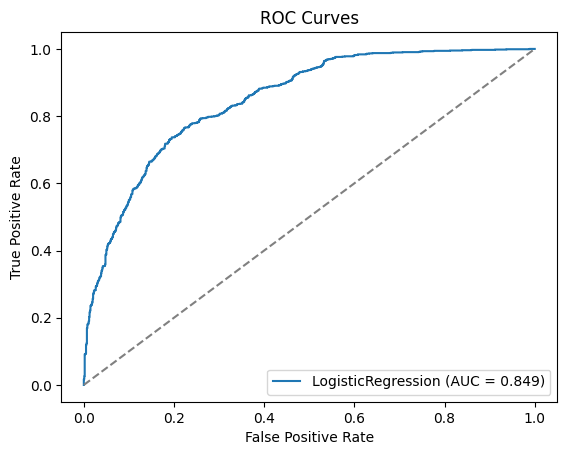

📊 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1021
           1       0.83      0.86      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



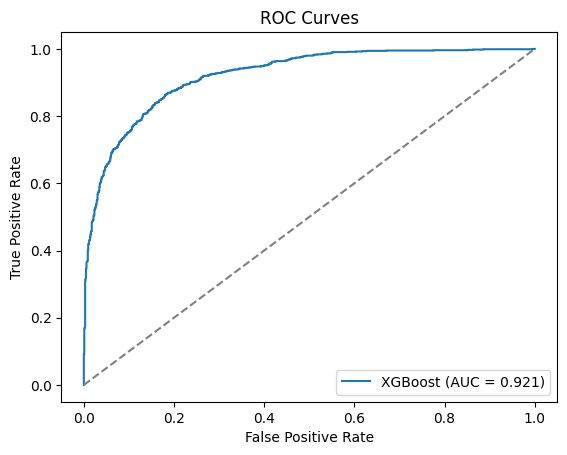

[LightGBM] [Info] Number of positive: 4125, number of negative: 4153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4315
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498309 -> initscore=-0.006765
[LightGBM] [Info] Start training from score -0.006765
📊 LightGBM Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1021
           1       0.83      0.85      0.84      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



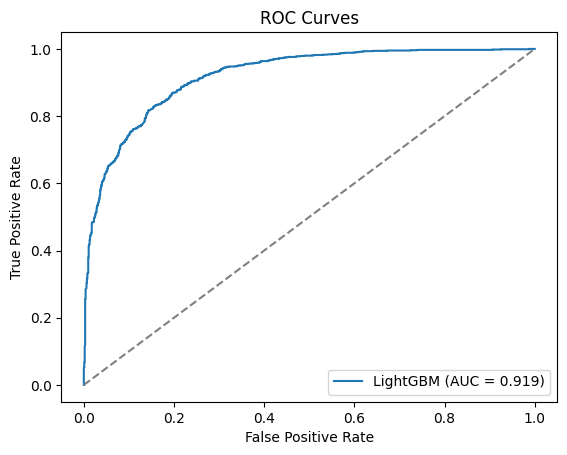

📊 CatBoost Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1021
           1       0.83      0.85      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



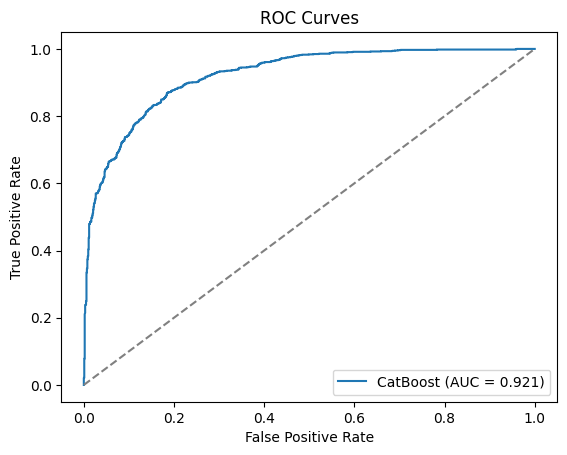

📊 RandomForest Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1021
           1       0.85      0.86      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



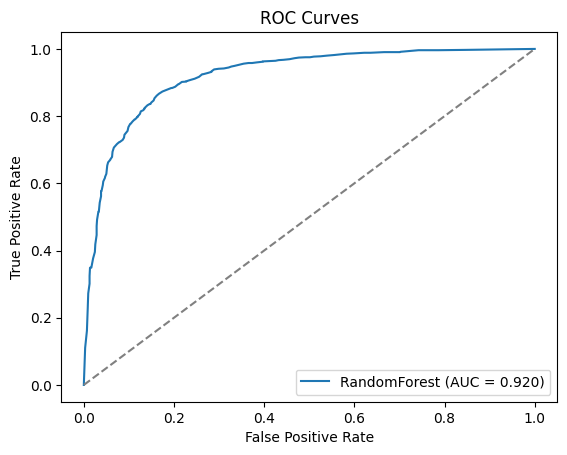

[LightGBM] [Info] Number of positive: 4125, number of negative: 4153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4315
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498309 -> initscore=-0.006765
[LightGBM] [Info] Start training from score -0.006765
[LightGBM] [Info] Number of positive: 3300, number of negative: 3322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4314
[LightGBM] [Info] Number of data points in the train set: 6622, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498339 -> initscore=-0.006645
[LightGBM] [Info] Start training from score -0.006645
[LightGBM] [Info] 

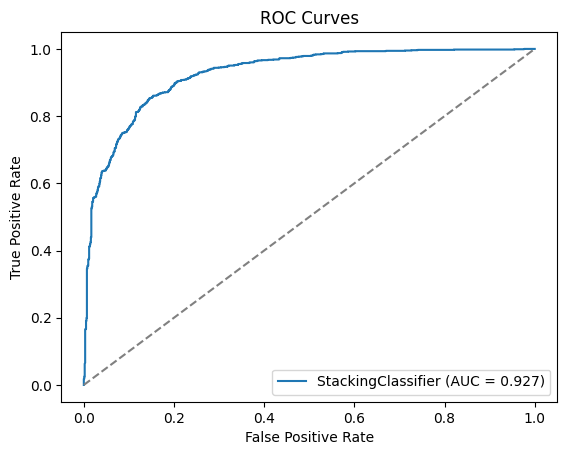

In [29]:
models = {
    "LogisticRegression": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "RandomForest": RandomForestClassifier(),
    "StackingClassifier": stacking_clf
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    results[name] = {"Accuracy": acc, "ROC_AUC": roc_auc}

    print(f"📊 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

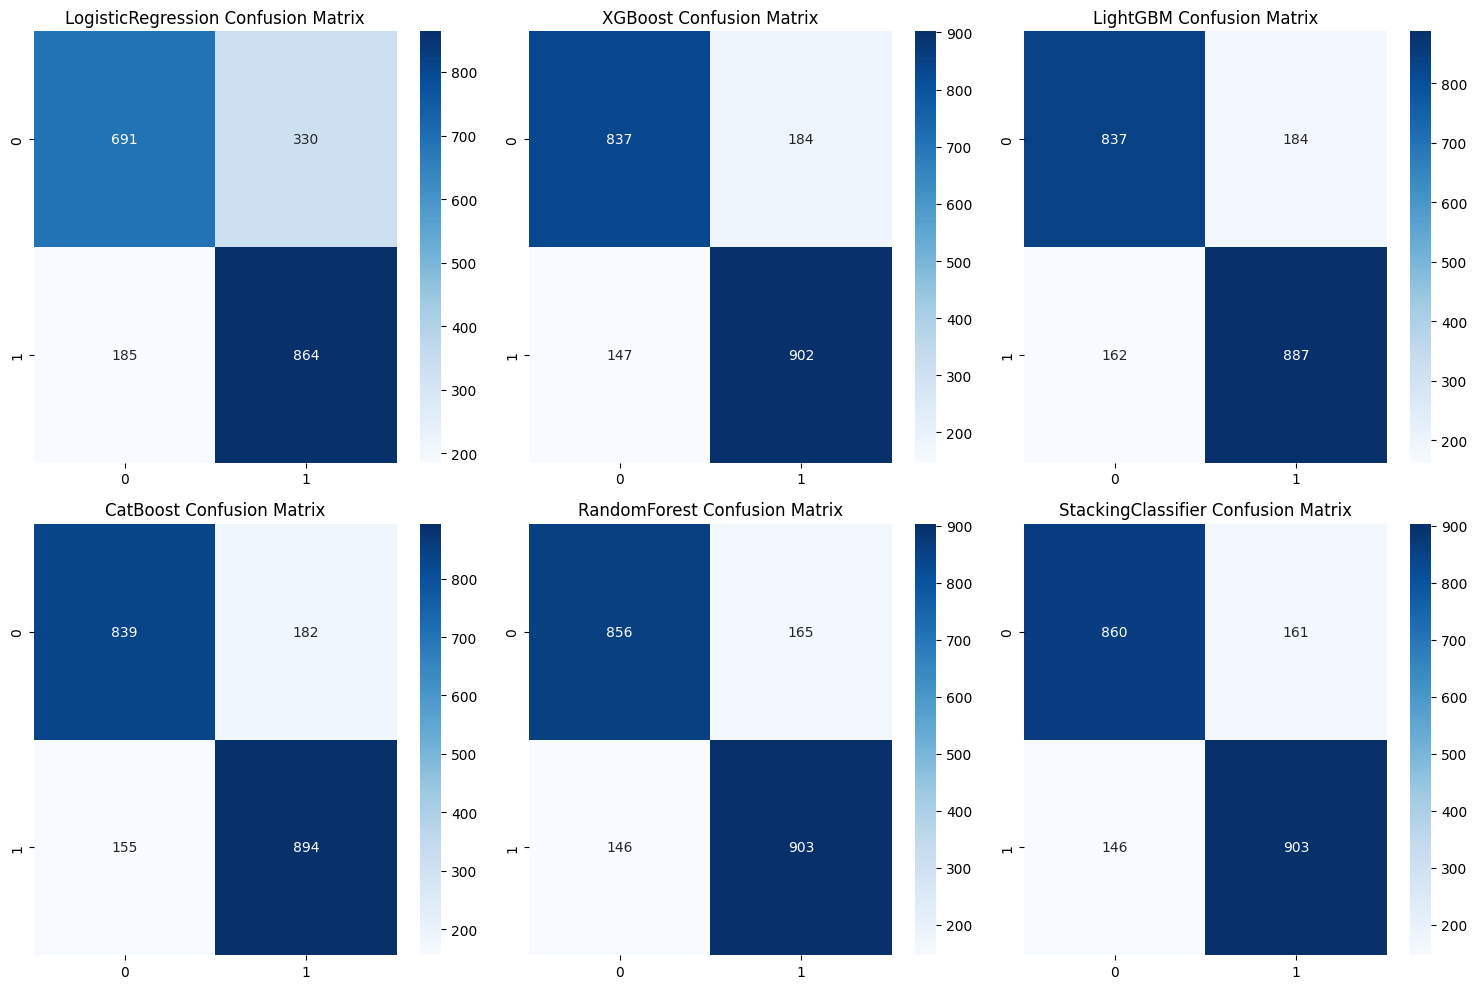

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (name, model) in zip(axes.flatten(), models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

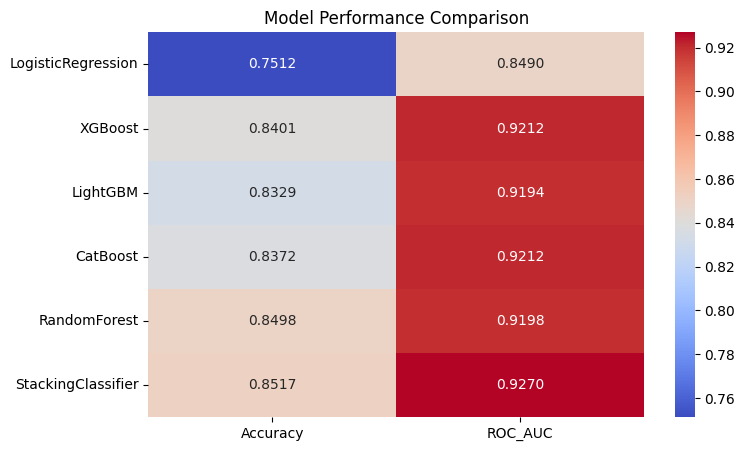

In [31]:
df_results = pd.DataFrame(results).T
plt.figure(figsize=(8, 5))
sns.heatmap(df_results, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Model Performance Comparison")
plt.show()

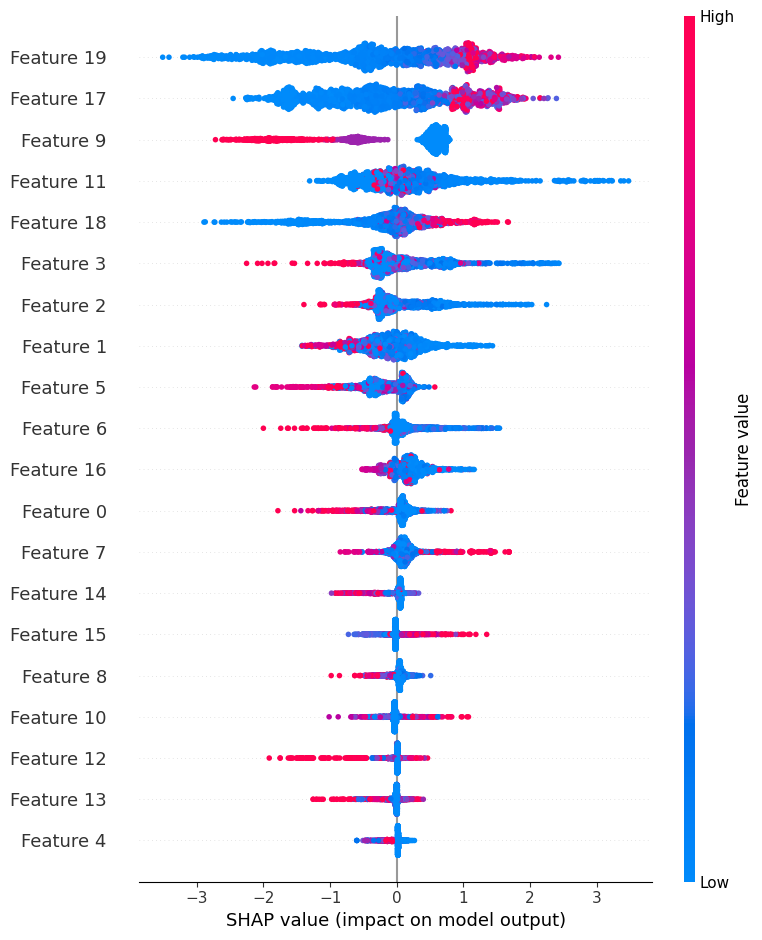

In [33]:
shap.initjs()
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [34]:
def business_impact(y_true, y_pred, revenue_per_customer=1000, cost_per_intervention=200):
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    churn_loss = false_negatives * revenue_per_customer
    interventions = np.sum(y_pred == 1) * cost_per_intervention
    total_loss = churn_loss + interventions
    net_loss=churn_loss - interventions

    total_revenue = len(y_true) * revenue_per_customer
    churn_loss_percent = (churn_loss / total_revenue) * 100
    intervention_savings_percent = (interventions / total_revenue) * 100

    print(f"Total Revenue: {total_revenue}")
    print(f"Estimated Churn Loss: ${churn_loss} ({churn_loss_percent:.2f}% of total revenue)")
    print(f"Estimated Intervention Cost: ${interventions} ({intervention_savings_percent:.2f}% of total revenue)")
    print(f"Total Financial Impact: ${total_loss}")
    print(f"Total Net Loss: ${net_loss}")

business_impact(y_test, models["StackingClassifier"].predict(X_test))

Total Revenue: 2070000
Estimated Churn Loss: $146000 (7.05% of total revenue)
Estimated Intervention Cost: $212800 (10.28% of total revenue)
Total Financial Impact: $358800
Total Net Loss: $-66800
